# Técnicas de Machine Learning para Classificação Supervisionada de Contas Bots do Twitter.

## FIA LABDATA - Turma 13

### Fabio Daleffi

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None

In [4]:
df_original = pd.read_csv('classified_twitter_accounts.csv')

In [5]:
df_original.columns

Index(['id', 'name', 'screen_name', 'statuses_count', 'followers_count',
       'friends_count', 'favourites_count', 'listed_count', 'lang',
       'default_profile', 'default_profile_image', 'geo_enabled', 'protected',
       'verified', 'classification', 'dataset', 'screen_name_total_len',
       'screen_name_num_len', 'name_total_len', 'name_num_len', 'is_url_null',
       'is_location_null', 'profile_banner_url_null', 'profile_image_url_null',
       'description_null'],
      dtype='object')

In [6]:
df_original.shape

(14368, 25)

In [7]:
# DROP FEATURES LIST

#ALTA CARDINALIDADE
alta_card = ['id','name', 'screen_name']

# ALTA CORRELACAO (IDENTIFICADA NA ANALISE EXPLORATORIA)
correlacao = ['listed_count']

construidas = [
    'screen_name_total_len',  
    'screen_name_num_len',       
    'name_total_len',            
    'name_num_len',              
    'is_url_null',               
    'is_location_null',          
    'profile_banner_url_null',   
    'profile_image_url_null',    
    'description_null'
] 


drop_features = alta_card + correlacao + construidas

# VARIAVEIS DE CONTROLE DO DATASET
drop_features.append('dataset')

df_accounts = df_original.drop(drop_features, axis=1)

In [8]:
# target
df_accounts['target'] = np.where(df_accounts.classification == "bot", 1, 0)
df_accounts.drop('classification', axis=1, inplace=True)

In [9]:
df_accounts.dtypes

statuses_count            int64
followers_count           int64
friends_count             int64
favourites_count          int64
lang                     object
default_profile            bool
default_profile_image      bool
geo_enabled                bool
protected                  bool
verified                   bool
target                    int32
dtype: object

In [10]:
df_accounts.shape

(14368, 11)

In [11]:
df_accounts.describe()

,statuses_count,followers_count,friends_count,favourites_count,target
count,14368.000000,1.436800e+04,14368.000000,14368.000000,14368.000000
mean,5063.190910,8.682774e+02,589.318834,1145.288280,0.758213
std,17493.409898,2.688472e+04,2665.832959,6036.894173,0.428181
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,31.000000,6.000000e+00,42.000000,0.000000,1.000000
50%,63.000000,2.500000e+01,250.000000,0.000000,1.000000
75%,1365.250000,3.320000e+02,538.000000,9.000000,1.000000
max,399555.000000,2.991573e+06,211890.000000,313954.000000,1.000000


# CATEGORIZANDO AS VARIÁVEIS

In [12]:
df = df_accounts.copy()

In [13]:
df['statuses_count'] = pd.cut(df.statuses_count, bins=[-1,31,63,1365,399555], labels=[
     '1 - DE 0 ATE 31'
    ,'2 - DE 32 ATE 63'
    ,'3 - DE 64 ATE 1365'
    ,'4 - ACIMA DE 1365'
] )

In [14]:
df['followers_count'] = pd.cut(df.followers_count, bins=[-1,6,25,332,2991573], labels=[
     '1 - DE 0 ATE 6'
    ,'2 - DE 7 ATE 25'
    ,'3 - DE 26 ATE 332'
    ,'4 - ACIMA DE 332'
] )

In [15]:
df['friends_count'] = pd.cut(df.friends_count, bins=[-1,42,250,538,211890], labels=[
     '1 - DE 0 ATE 42'
    ,'2 - DE 43 ATE 250'
    ,'3 - DE 251 ATE 538'
    ,'4 - ACIMA DE 538'
])

In [16]:
df['favourites_count'] = pd.cut(df.favourites_count, bins=[-1,9,313954], labels=[
     '1 - DE 0 ATE 9'
    ,'2 - ACIMA DE 9'
])

In [17]:
df['lang'] = np.where(df.lang == "en", 'ENGLISH', 'OTHERS')
df['lang'] = df['lang'].astype('category')

# Criar Dummies

In [18]:
cat_vars = df.drop('target', axis=1).columns

for var in cat_vars:

    cat_list='var' +'_'+ var
    cat_list = pd.get_dummies(df[var], prefix = var, drop_first=True)
    df=df.join(cat_list)

df.drop(cat_vars, axis = 1, inplace = True)

# Regressão Logística

In [19]:
X = df.drop('target', axis = 1)
y = df.target

## BACKWARD FEATURE REMOVAL
drop_list = [
    'protected_True',
    'verified_True',
    'statuses_count_2 - DE 32 ATE 63',
    'default_profile_image_True'
]

X.drop(drop_list, axis = 1, inplace = True)

In [20]:
import statsmodels.api as sm

X = sm.add_constant(X)
logit_model=sm.Logit(y, X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.089737
         Iterations 10
                                  Results: Logit
Model:                    Logit                  Pseudo R-squared:       0.838    
Dependent Variable:       target                 AIC:                    2604.6890
Date:                     2020-07-24 21:44       BIC:                    2703.1349
No. Observations:         14368                  Log-Likelihood:         -1289.3  
Df Model:                 12                     LL-Null:                -7947.4  
Df Residuals:             14355                  LLR p-value:            0.0000   
Converged:                1.0000                 Scale:                  1.0000   
No. Iterations:           10.0000                                                 
----------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
print('Accuracy no treino: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy no teste: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy no treino: 0.98
Accuracy no teste: 0.97


# MÉTRICAS TREINO

In [45]:
#MATRIZ CONFUSAO TREINO

from sklearn.metrics import confusion_matrix

y_pred_treino =  logreg.predict(X_train)
confusion_matrix_treino = confusion_matrix(y_train, y_pred_treino)
print(confusion_matrix_treino)

[[2317  109]
 [ 130 7501]]


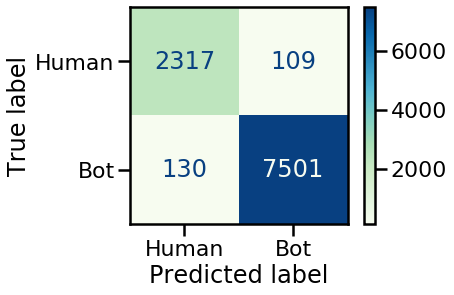

In [46]:
from sklearn.metrics import plot_confusion_matrix

labels = ['Human','Bot']
plot_confusion_matrix(logreg, X_train, y_train,  cmap = plt.cm.GnBu, display_labels= labels, values_format="");

In [57]:
TP = 7501
TN = 2317
FP = 109
FN = 130

Accuracy    = (TP + TN) / (TP+TN+FP+FN) * 100
Precision   = (TP/(TP+FP)) * 100
Specificity = (TN/(FP+TN)) * 100
Recall      = (TP/(TP+FN)) * 100

print('Accuracy: {:.2f}'.format(Accuracy))
print('Precision: {:.2f}'.format(Precision))
print('Specificity: {:.2f}'.format(Specificity))
print('Recall(Sensitivity): {:.2f}'.format(Specificity))

Accuracy: 97.62
Precision: 98.57
Specificity: 95.51
Recall(Sensitivity): 95.51


# MÉTRICAS TESTE

In [23]:
#MATRIZ CONFUSAO TESTE

from sklearn.metrics import confusion_matrix

y_pred =  logreg.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1001   47]
 [  68 3195]]


TN | FP <br>
FN | TP

Matriz de confusão do SKLearn é reversa

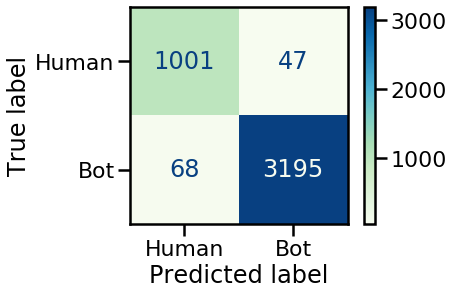

In [34]:
from sklearn.metrics import plot_confusion_matrix

labels = ['Human','Bot']
plot_confusion_matrix(logreg, X_test, y_test,  cmap = plt.cm.GnBu, display_labels= labels, values_format="");
#plot_confusion_matrix(logreg, X_test, y_test, cmap = plt.cm.GnBu);

In [58]:
TP = 3195
TN = 1001
FP = 47
FN = 68

Accuracy    = (TP + TN) / (TP+TN+FP+FN) * 100
Precision   = (TP/(TP+FP)) * 100
Specificity = (TN/(FP+TN)) * 100
Recall      = (TP/(TP+FN)) * 100

print('Accuracy: {:.2f}'.format(Accuracy))
print('Precision: {:.2f}'.format(Precision))
print('Specificity: {:.2f}'.format(Specificity))
print('Recall(Sensitivity): {:.2f}'.format(Specificity))

Accuracy: 97.33
Precision: 98.55
Specificity: 95.52
Recall(Sensitivity): 95.52


In [26]:
# Define function to output plot of the model coefficients

def coefplot(results):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    coef_df = coef_df.drop(['const'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar',
                 ax=ax, color='none', fontsize=22, 
                 ecolor='steelblue',capsize=0,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title('Coeficientes com Intervalo de Confiança de 95%',fontsize=30)
    ax.set_ylabel('Coeficientes',fontsize=22)
    ax.set_xlabel('',fontsize=22)
    
    # Coefficients
    ax.scatter(x=np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['coef'], color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    return plt.show()

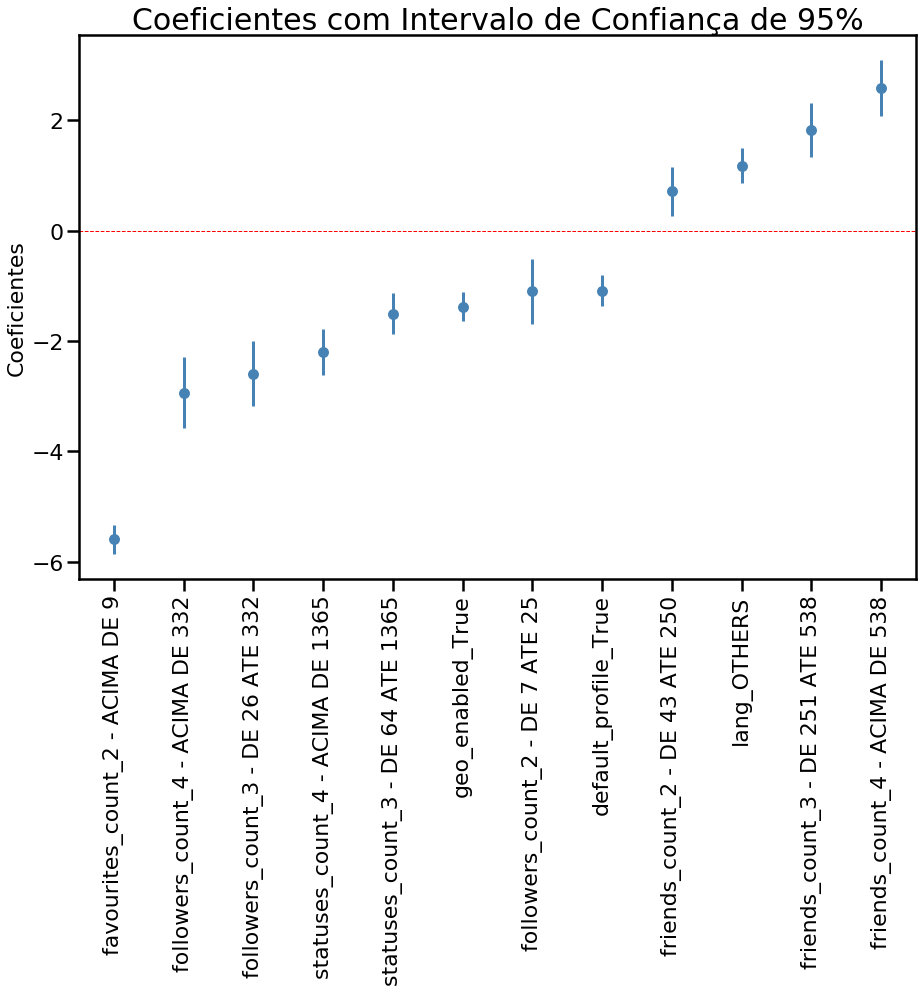

In [27]:
coef_df = coefplot(result)